Project 4 "Fletcher" Notebook 2:  
**Pulling data from MongoDB and text analysis/NLP**  
  
Adam Flugel  
Metis Boot Camp, Chicago  
Winter 2018

In [1]:
from pymongo import MongoClient

import numpy as np
import pandas as pd
import re
import os
import string

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, NMF

import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

from gensim import corpora, models, similarities, matutils

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Data prep

## Pull all data from mongo

In [ ]:
#connect to mongo and select the proper collection
client = MongoClient(port=12345)
db = client.new_dank_database

collection = db.monologues

In [ ]:
df = pd.DataFrame(columns=['_id','title','author','category','text'])

for doc in collection.find():
    df = df.append(doc, ignore_index=True)

In [ ]:
df.head(3)

In [ ]:
df['topcategory'] = [cat[0] for cat in df.category.values]

In [ ]:
#making a new column that categorizes monologues into male, female, children, seniors
for index, category in enumerate(df.topcategory):
    if re.match('.*women', category):
        df.loc[index,'actor_type'] = 'female'
    elif re.match('.*men', category):
        df.loc[index, 'actor_type'] = 'male'
    else:
        df.loc[index, 'actor_type'] = category

In [ ]:
for index, category in enumerate(df.category.astype(str)):
    if re.match('.*classic', category):
        df.loc[index,'classic_modern'] = 'classic'
    else:
        df.loc[index, 'classic_modern'] = 'modern'

In [ ]:
df.head(2)

In [ ]:
len(df) #making sure I got all the data

In [ ]:
#saving all pulled data as pickle for future local access
df.to_pickle('df_all.gz')

In [2]:
df = pd.read_pickle('df_all.gz')

## Pull out datasets of specific categories

In [3]:
df.category.astype(str).value_counts()

['drama_men']                                  71
['drama_women']                                59
['drama_men', 'classic_men']                   48
['drama_women', 'classic_women']               46
['classic_men']                                41
['comic_women']                                32
['comic_men']                                  29
['comic_men', 'classic_men']                   28
['classic_women']                              22
['drama_men', 'seniors']                       14
['seniors']                                    13
['children']                                   12
['comic_women', 'classic_women']               10
['classic_men', 'seniors']                      7
['drama_men', 'classic_men', 'seniors']         7
['comic_men', 'seniors']                        7
['seniors', 'drama_women', 'classic_women']     5
['seniors', 'drama_women']                      3
['seniors', 'classic_women']                    3
['comic_men', 'classic_men', 'seniors']         3


### Drama_Men

In [4]:
df_drama_men = df.loc[df.category.astype(str)=='[\'drama_men\']',:]

In [5]:
df_drama_men.head(2)

,_id,title,author,category,text,topcategory,actor_type,classic_modern
5,5a9db0bfa787026d63428f86,An Enemy Of The People,Henrik Ibsen,[drama_men],"Oh, the public has no need for new ideas. The ...",drama_men,male,modern
8,5a9db0bfa787026d63428f89,Marlowe,Josephine Preston Peabody,[drama_men],"Hands off, I say! Stay then, and every devil m...",drama_men,male,modern


### Classic vs. Modern

In [6]:
df_classic = df.loc[df.classic_modern=='classic',:]
df_classic.head(2)

,_id,title,author,category,text,topcategory,actor_type,classic_modern
1,5a9db0bfa787026d63428f82,Medea,Euripides,"[drama_women, classic_women]",O my sons! My sons! ye have a city and a house...,drama_women,female,classic
2,5a9db0bfa787026d63428f83,As You Like It,William Shakespeare,"[comic_women, classic_women]","Think not I love him, though I ask for him; 'T...",comic_women,female,classic


In [7]:
df_modern = df.loc[df.classic_modern=='modern',:]
df_modern.head(2)

,_id,title,author,category,text,topcategory,actor_type,classic_modern
0,5a9db0bfa787026d63428f81,The Profession,Walter Wykes,[comic_men],Hey! Don't touch that! That's my orange! MINE!...,comic_men,male,modern
3,5a9db0bfa787026d63428f84,Maddalena Speaks,Neith Boyce,[drama_women],"Listen, Signora! I am speaking, I, Maddalena, ...",drama_women,female,modern


### Men vs. Women

In [8]:
df_men = df.loc[df.actor_type=='male',:]
df_men.head(2)

,_id,title,author,category,text,topcategory,actor_type,classic_modern
0,5a9db0bfa787026d63428f81,The Profession,Walter Wykes,[comic_men],Hey! Don't touch that! That's my orange! MINE!...,comic_men,male,modern
4,5a9db0bfa787026d63428f85,When We Dead Awaken,Henrik Ibsen,"[drama_men, seniors]",When I first found you ... I knew at once I wo...,drama_men,male,modern


In [9]:
df_fem = df.loc[df.actor_type=='female',:]
df_fem.head(2)

,_id,title,author,category,text,topcategory,actor_type,classic_modern
1,5a9db0bfa787026d63428f82,Medea,Euripides,"[drama_women, classic_women]",O my sons! My sons! ye have a city and a house...,drama_women,female,classic
2,5a9db0bfa787026d63428f83,As You Like It,William Shakespeare,"[comic_women, classic_women]","Think not I love him, though I ask for him; 'T...",comic_women,female,classic


## Setting Stop-Words

In [10]:
#adding stop words to the standard english set from nltk in order to account for 'theater-y' words
my_stopwords = set(stopwords.words('english'))
my_stopwords.update(['thy', 'thou', 'shall', 'like', 'thee', 'one', 'would', 'say', 'st', 'ah',
                    'no', 'never', 'must', 'well', 'may', 'could', 'see', 'know', 'go', 'us',
                    'yet', 'come', 'back', 'said', 'de', 'en', 'says', 'little', 'good', 'em',
                    'upon', 'let', 'make', 'made', 'day', 'tell', 'think', 'going', 'want',
                    'much', 'even', 'still', 'first', 'ever', 'ye', 'oh', 'oi', 'every', 'thing',
                    'things', 'yes', 'got', 'tis', 'went', 'saw', 'hath', 'anything', 'er', 'uz', 'dat',
                    'nothing', 'something', 'ha', 'mine'])

# PCA

In [11]:
texts = df.text
categories = df.actor_type
era = df.classic_modern

In [12]:
def get_vectorizer(vectorizer_string='count', stopwords=my_stopwords, df_min=1, df_max=1.0):
    
    assert (vectorizer_string=='count') or (vectorizer_string=='tfidf'), \
            'You must choose \'count\' or \'tfidf\' for your vectorizer string!'
    
    if vectorizer_string == 'count':
         vectorizer = CountVectorizer(stop_words=stopwords, token_pattern="\\b[a-z][a-z]+\\b",
                                    min_df=df_min, max_df=df_max)
    else:
        vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern="\\b[a-z][a-z]+\\b",
                                    min_df=df_min, max_df=df_max)
    
    return vectorizer


def PCA_generator(text, dim=2, stopwords=my_stopwords, vectorizer='count', df_min=1, df_max=1.0):
    
    assert (type(dim) == int)&(dim > 0), 'Dim must be a positive int!'
    
    vectorizer = get_vectorizer(vectorizer, stopwords, df_min, df_max)
    vectorizer.fit(text)
    counts = vectorizer.transform(text)
    
    pca = PCA(n_components = dim)
    pca.fit(counts.toarray())
    pca_transform = pca.transform(counts.toarray())
    
    return pca, pca_transform


def plot_PCA_2D(features, targets=False, colors=False, title="PCA"):
    """Plots 2d PCA results, optionally coloring points based on target value, if target value array is provided.
    Colors must be a LIST of desired colors for each category.
    
    User defined colors are optional if less than 4 target categories are provided,
    but there are no default colors set for more than 4 categories.
    
    If no target is provided, color for all points can be set with a list of a singular color
    
    title can be set by user, or defaults to 'PCA'"""

    plt.figure(figsize=(8,8))
    
    if targets is False:
        if colors is False:
            colors = ['blue']
            
        plt.scatter(features[:,0], features[:,1], c=colors[0], edgecolors='black', alpha=0.6) 
        
    else:
        if colors is False:
            colors = ['red','magenta','blue','yellow']
        
        target_names = np.unique(targets)
        
        for color, category in zip(colors, target_names):
            plt.scatter(features[targets == category, 0], features[targets == category, 1],
                       c=color, label=category, edgecolors='black', alpha=0.6)
        plt.legend(fontsize=15)
        
    
    plt.title(title, size=25)
    plt.xlabel("Primary Component 1", size=20)
    plt.ylabel("Primary Component 2", size=20)


def plot_PCA_3D(features, targets=False, colors=False, title="PCA: 3D"):
    """Plots 3d PCA results, optionally coloring points based on target value, if target value array is provided.
    Colors must be a LIST of desired colors for each category.
    
    User defined colors are optional if less than 4 target categories are provided,
    but there are no default colors set for more than 4 categories.
    
    If no target is provided, color for all points can be set with a list of a singular color
    
    title can be set by user, or defaults to 'PCA: 3D'"""
    
    traces = []
    
    if targets is False:
        if colors is False:
            colors = ['blue']
        
        x = features[:, 0]
        y = features[:, 1]
        z = features[:, 2]

        trace = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                marker=dict(size=3,
                                            color=colors[0],
                                            line=dict(
                                                color='black',
                                                width=0.25),
                                            opacity=0.8))
        traces.append(trace)

    else:    
        target_names = np.unique(targets)
        
        if colors is False:
            #red, pink, blue, yellow
            colors = ['red','magenta','blue','yellow']

        for color, category in zip(colors, target_names):
            x = features[targets == category, 0]
            y = features[targets == category, 1]
            z = features[targets == category, 2]

            trace = go.Scatter3d(x=x, y=y, z=z, mode='markers', name=category,
                                    marker=dict(size=3,
                                                color=color,
                                                line=dict(
                                                    color='black',
                                                    width=0.25),
                                                opacity=0.8))
            traces.append(trace)

    data = traces
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig, filename='simple-3d-scatter')

## PCA: CountVectorizer

In [13]:
pca_cv, pca_cv_transform = PCA_generator(texts, dim=2, vectorizer='count')

pca_cv.explained_variance_ratio_

array([0.02244409, 0.02061261])

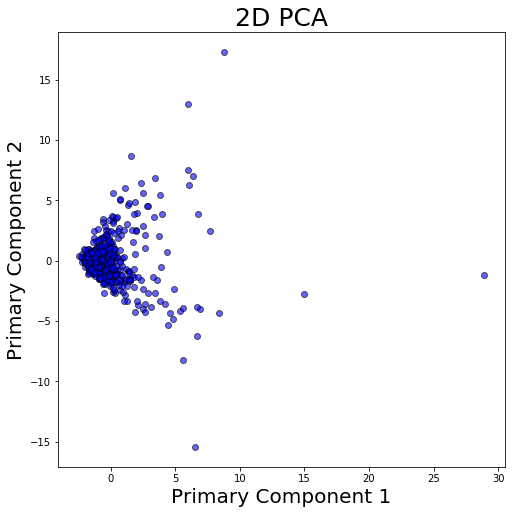

In [14]:
plot_PCA_2D(pca_cv_transform, title="2D PCA")

(-17.451014797146485, 19.32871198116711)

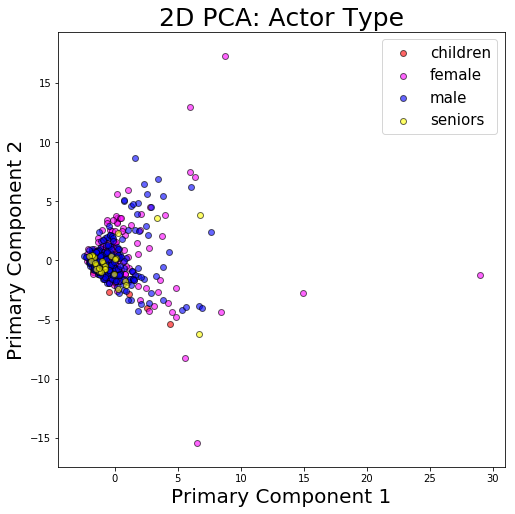

In [15]:
plot_PCA_2D(pca_cv_transform, categories.values, title="2D PCA: Actor Type")

plt.xlim(pca_cv_transform[:,0].min() - 2, pca_cv_transform[:,0].max() + 2)
plt.ylim(pca_cv_transform[:,1].min() - 2, pca_cv_transform[:,1].max() + 2)

(-17.451014797146485, 19.32871198116711)

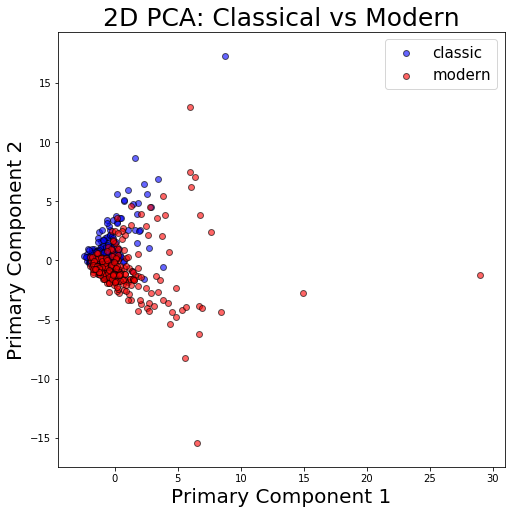

In [16]:
plot_PCA_2D(pca_cv_transform, era.values, colors = ['blue', 'red'], title='2D PCA: Classical vs Modern')

plt.xlim(pca_cv_transform[:,0].min() - 2, pca_cv_transform[:,0].max() + 2)
plt.ylim(pca_cv_transform[:,1].min() - 2, pca_cv_transform[:,1].max() + 2)

## PCA: Tfidf Vectorizer

In [17]:
pca_tf, pca_tf_transform = PCA_generator(texts, dim=2, vectorizer='tfidf')

pca_tf.explained_variance_ratio_

array([0.0087113 , 0.00617929])

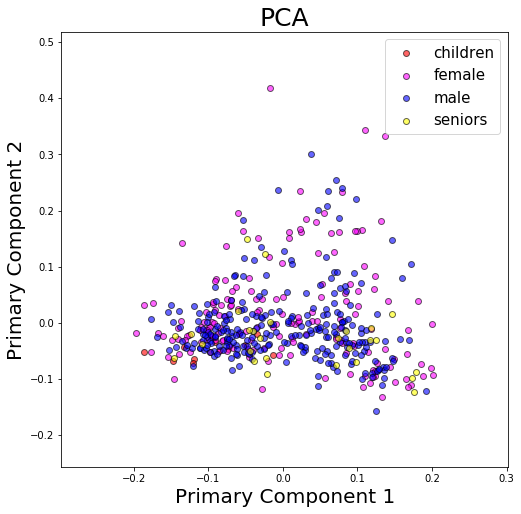

In [18]:
plot_PCA_2D(pca_tf_transform, categories.values)
plt.xlim(pca_tf_transform[:,0].min() - 0.1, pca_tf_transform[:,0].max() + 0.1)
plt.ylim(pca_tf_transform[:,1].min() - 0.1, pca_tf_transform[:,1].max() + 0.1);

## PCA - 3d (CountVectorizer)  

In [19]:
pca3d_cv, pca3d_cv_transform = PCA_generator(texts, dim=3, vectorizer='count', df_min=15, df_max=0.95)

pca3d_cv.explained_variance_ratio_

array([0.03909371, 0.03516501, 0.02582962])

In [20]:
plot_PCA_3D(pca3d_cv_transform)

In [21]:
plot_PCA_3D(pca3d_cv_transform, era.values, colors=['red','blue'])

In [22]:
plot_PCA_3D(pca3d_cv_transform, categories.values)

## PCA - 3d (TF-IDF)  

In [23]:
pca3d_tf, pca3d_tf_transform = PCA_generator(texts, dim=3, vectorizer='tfidf', df_min=15, df_max=0.8)

pca3d_tf.explained_variance_ratio_

array([0.02042892, 0.01432848, 0.01043025])

In [24]:
#plotting the 3d PCA results
plot_PCA_3D(pca3d_tf_transform, categories.values)

# LDA

In [25]:
def LDA_generator(text, n_topics=3, stopwords=my_stopwords, vectorizer='count',
                  df_min=1, df_max=1.0, n_passes=10, n_iterations=50):
    
    assert (type(n_topics) == int)&(n_topics > 0), 'n_topics must be a positive int!'
    
    vectorizer = get_vectorizer(vectorizer, stopwords, df_min, df_max)
    vectorizer.fit(text)
    counts = vectorizer.transform(text).transpose()
    
    corpus = matutils.Sparse2Corpus(counts)
    
    id2words = dict((v, k) for k, v in vectorizer.vocabulary_.items())
    
    lda = models.LdaModel(corpus=corpus, num_topics=n_topics, id2word=id2words,
                          passes=n_passes, iterations=n_iterations)
    
    return lda, corpus

## LDA - CountVectorizer

### All categories

In [26]:
lda_all, corpus_all = LDA_generator(texts, n_topics=2, df_min=3, df_max=0.2)

2018-03-12 12:51:40,423 : INFO : using symmetric alpha at 0.5
2018-03-12 12:51:40,424 : INFO : using symmetric eta at 0.5
2018-03-12 12:51:40,425 : INFO : using serial LDA version on this node
2018-03-12 12:51:40,428 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 465 documents, updating model once every 465 documents, evaluating perplexity every 465 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:51:41,124 : INFO : -8.854 per-word bound, 462.7 perplexity estimate based on a held-out corpus of 465 documents with 53633 words
2018-03-12 12:51:41,125 : INFO : PROGRESS: pass 0, at document #465/465
2018-03-12 12:51:41,471 : INFO : topic #0 (0.500): 0.003*"child" + 0.003*"wife" + 0.002*"hand" + 0.002*"blood" + 0.002*"women" + 0.002*"hands" + 0.002*"young" + 0.002*"whose" + 0.002*"years" + 0.002*"another"
2018-03-12 12:51:41,472 : INFO : topic #1 (0.500): 0.002*"husband" + 0.002*"son" + 0.002*"live" + 0.002*"t

In [27]:
lda_all.print_topics()

2018-03-12 12:51:55,251 : INFO : topic #0 (0.500): 0.003*"years" + 0.003*"young" + 0.003*"put" + 0.003*"work" + 0.003*"wife" + 0.003*"child" + 0.003*"women" + 0.002*"everything" + 0.002*"enough" + 0.002*"three"
2018-03-12 12:51:55,251 : INFO : topic #1 (0.500): 0.004*"whose" + 0.003*"blood" + 0.003*"heaven" + 0.003*"thus" + 0.003*"son" + 0.003*"hand" + 0.003*"gods" + 0.003*"voice" + 0.002*"soul" + 0.002*"husband"


[(0,
  '0.003*"years" + 0.003*"young" + 0.003*"put" + 0.003*"work" + 0.003*"wife" + 0.003*"child" + 0.003*"women" + 0.002*"everything" + 0.002*"enough" + 0.002*"three"'),
 (1,
  '0.004*"whose" + 0.003*"blood" + 0.003*"heaven" + 0.003*"thus" + 0.003*"son" + 0.003*"hand" + 0.003*"gods" + 0.003*"voice" + 0.002*"soul" + 0.002*"husband"')]

In [28]:
topic_scores = lda_all[corpus_all]
[doc for doc in topic_scores][0:10]

[[(0, 0.9969396)],
 [(1, 0.9968581)],
 [(0, 0.6866416), (1, 0.31335843)],
 [(0, 0.9936332)],
 [(0, 0.9891241), (1, 0.010875854)],
 [(0, 0.5733889), (1, 0.42661113)],
 [(0, 0.98955405), (1, 0.010445997)],
 [(0, 0.9957261)],
 [(0, 0.17615373), (1, 0.8238462)],
 [(0, 0.9885443), (1, 0.01145572)]]

### Drama_Men

In [29]:
dmtexts = df_drama_men.text

lda_dm, corpus_dm = LDA_generator(dmtexts, n_topics=3, df_min=3, df_max=0.95)

2018-03-12 12:51:58,075 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-12 12:51:58,075 : INFO : using symmetric eta at 0.3333333333333333
2018-03-12 12:51:58,076 : INFO : using serial LDA version on this node
2018-03-12 12:51:58,077 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 71 documents, updating model once every 71 documents, evaluating perplexity every 71 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:51:58,180 : INFO : -7.342 per-word bound, 162.3 perplexity estimate based on a held-out corpus of 71 documents with 6505 words
2018-03-12 12:51:58,181 : INFO : PROGRESS: pass 0, at document #71/71
2018-03-12 12:51:58,238 : INFO : topic #0 (0.333): 0.018*"man" + 0.008*"work" + 0.007*"time" + 0.007*"old" + 0.007*"people" + 0.006*"new" + 0.006*"love" + 0.006*"came" + 0.005*"way" + 0.005*"life"
2018-03-12 12:51:58,238 : INFO : topic #1 (0.333): 0.012*"man" + 0.008*"life" + 0.008*"love" + 

2018-03-12 12:51:59,317 : INFO : topic diff=0.032629, rho=0.316228
2018-03-12 12:51:59,407 : INFO : -6.694 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 71 documents with 6505 words
2018-03-12 12:51:59,408 : INFO : PROGRESS: pass 9, at document #71/71
2018-03-12 12:51:59,445 : INFO : topic #0 (0.333): 0.020*"man" + 0.009*"old" + 0.009*"new" + 0.008*"work" + 0.007*"woman" + 0.007*"take" + 0.007*"wife" + 0.007*"love" + 0.007*"time" + 0.006*"look"
2018-03-12 12:51:59,446 : INFO : topic #1 (0.333): 0.010*"man" + 0.008*"love" + 0.007*"life" + 0.007*"men" + 0.007*"thought" + 0.006*"god" + 0.006*"time" + 0.006*"way" + 0.006*"mr" + 0.006*"heart"
2018-03-12 12:51:59,447 : INFO : topic #2 (0.333): 0.011*"life" + 0.009*"people" + 0.008*"thought" + 0.008*"man" + 0.007*"child" + 0.007*"time" + 0.007*"came" + 0.007*"house" + 0.006*"god" + 0.006*"get"
2018-03-12 12:51:59,448 : INFO : topic diff=0.027030, rho=0.301511


In [30]:
lda_dm.print_topics()

2018-03-12 12:52:00,895 : INFO : topic #0 (0.333): 0.020*"man" + 0.009*"old" + 0.009*"new" + 0.008*"work" + 0.007*"woman" + 0.007*"take" + 0.007*"wife" + 0.007*"love" + 0.007*"time" + 0.006*"look"
2018-03-12 12:52:00,896 : INFO : topic #1 (0.333): 0.010*"man" + 0.008*"love" + 0.007*"life" + 0.007*"men" + 0.007*"thought" + 0.006*"god" + 0.006*"time" + 0.006*"way" + 0.006*"mr" + 0.006*"heart"
2018-03-12 12:52:00,896 : INFO : topic #2 (0.333): 0.011*"life" + 0.009*"people" + 0.008*"thought" + 0.008*"man" + 0.007*"child" + 0.007*"time" + 0.007*"came" + 0.007*"house" + 0.006*"god" + 0.006*"get"


[(0,
  '0.020*"man" + 0.009*"old" + 0.009*"new" + 0.008*"work" + 0.007*"woman" + 0.007*"take" + 0.007*"wife" + 0.007*"love" + 0.007*"time" + 0.006*"look"'),
 (1,
  '0.010*"man" + 0.008*"love" + 0.007*"life" + 0.007*"men" + 0.007*"thought" + 0.006*"god" + 0.006*"time" + 0.006*"way" + 0.006*"mr" + 0.006*"heart"'),
 (2,
  '0.011*"life" + 0.009*"people" + 0.008*"thought" + 0.008*"man" + 0.007*"child" + 0.007*"time" + 0.007*"came" + 0.007*"house" + 0.006*"god" + 0.006*"get"')]

### Classic

In [31]:
classic_texts = df_classic.text

lda_classic, corpus_classic = LDA_generator(classic_texts, n_topics=2, df_min=3, df_max=0.7)

2018-03-12 12:52:03,067 : INFO : using symmetric alpha at 0.5
2018-03-12 12:52:03,068 : INFO : using symmetric eta at 0.5
2018-03-12 12:52:03,069 : INFO : using serial LDA version on this node
2018-03-12 12:52:03,070 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 220 documents, updating model once every 220 documents, evaluating perplexity every 220 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:52:03,408 : INFO : -8.349 per-word bound, 326.1 perplexity estimate based on a held-out corpus of 220 documents with 26165 words
2018-03-12 12:52:03,409 : INFO : PROGRESS: pass 0, at document #220/220
2018-03-12 12:52:03,581 : INFO : topic #0 (0.500): 0.007*"love" + 0.005*"man" + 0.004*"life" + 0.004*"eyes" + 0.004*"father" + 0.004*"heaven" + 0.004*"death" + 0.003*"thus" + 0.003*"hand" + 0.003*"heart"
2018-03-12 12:52:03,582 : INFO : topic #1 (0.500): 0.010*"love" + 0.007*"father" + 0.006*"man" + 0.005*"men" + 

In [32]:
lda_classic.print_topics()

2018-03-12 12:52:08,707 : INFO : topic #0 (0.500): 0.008*"love" + 0.005*"man" + 0.005*"heart" + 0.004*"eyes" + 0.004*"soul" + 0.004*"life" + 0.004*"death" + 0.004*"hand" + 0.004*"blood" + 0.004*"thine"
2018-03-12 12:52:08,709 : INFO : topic #1 (0.500): 0.009*"love" + 0.007*"father" + 0.006*"man" + 0.005*"men" + 0.005*"life" + 0.005*"whose" + 0.004*"thus" + 0.004*"mother" + 0.004*"eyes" + 0.004*"death"


[(0,
  '0.008*"love" + 0.005*"man" + 0.005*"heart" + 0.004*"eyes" + 0.004*"soul" + 0.004*"life" + 0.004*"death" + 0.004*"hand" + 0.004*"blood" + 0.004*"thine"'),
 (1,
  '0.009*"love" + 0.007*"father" + 0.006*"man" + 0.005*"men" + 0.005*"life" + 0.005*"whose" + 0.004*"thus" + 0.004*"mother" + 0.004*"eyes" + 0.004*"death"')]

### Modern

In [33]:
modern_texts = df_modern.text

lda_modern, corpus_modern = LDA_generator(modern_texts, n_topics=3, df_min=3, df_max=0.6)

2018-03-12 12:52:11,218 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-12 12:52:11,219 : INFO : using symmetric eta at 0.3333333333333333
2018-03-12 12:52:11,220 : INFO : using serial LDA version on this node
2018-03-12 12:52:11,222 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 245 documents, updating model once every 245 documents, evaluating perplexity every 245 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:52:11,575 : INFO : -8.354 per-word bound, 327.1 perplexity estimate based on a held-out corpus of 245 documents with 29455 words
2018-03-12 12:52:11,576 : INFO : PROGRESS: pass 0, at document #245/245
2018-03-12 12:52:11,759 : INFO : topic #0 (0.333): 0.007*"man" + 0.006*"time" + 0.006*"love" + 0.006*"men" + 0.005*"way" + 0.005*"right" + 0.004*"take" + 0.004*"look" + 0.004*"thought" + 0.004*"years"
2018-03-12 12:52:11,760 : INFO : topic #1 (0.333): 0.009*"love" + 0.007*"man" + 0.00

2018-03-12 12:52:15,771 : INFO : topic diff=0.038607, rho=0.316228
2018-03-12 12:52:16,098 : INFO : -7.439 per-word bound, 173.6 perplexity estimate based on a held-out corpus of 245 documents with 29455 words
2018-03-12 12:52:16,099 : INFO : PROGRESS: pass 9, at document #245/245
2018-03-12 12:52:16,253 : INFO : topic #0 (0.333): 0.007*"right" + 0.006*"way" + 0.005*"man" + 0.005*"time" + 0.004*"men" + 0.004*"take" + 0.004*"look" + 0.004*"get" + 0.003*"eyes" + 0.003*"name"
2018-03-12 12:52:16,254 : INFO : topic #1 (0.333): 0.011*"love" + 0.007*"man" + 0.006*"time" + 0.005*"get" + 0.005*"look" + 0.005*"life" + 0.004*"voice" + 0.004*"long" + 0.004*"hear" + 0.004*"without"
2018-03-12 12:52:16,254 : INFO : topic #2 (0.333): 0.012*"man" + 0.007*"men" + 0.007*"life" + 0.006*"thought" + 0.006*"way" + 0.005*"time" + 0.005*"take" + 0.005*"people" + 0.005*"came" + 0.005*"woman"
2018-03-12 12:52:16,255 : INFO : topic diff=0.032861, rho=0.301511


In [34]:
lda_modern.print_topics()

2018-03-12 12:52:16,398 : INFO : topic #0 (0.333): 0.007*"right" + 0.006*"way" + 0.005*"man" + 0.005*"time" + 0.004*"men" + 0.004*"take" + 0.004*"look" + 0.004*"get" + 0.003*"eyes" + 0.003*"name"
2018-03-12 12:52:16,399 : INFO : topic #1 (0.333): 0.011*"love" + 0.007*"man" + 0.006*"time" + 0.005*"get" + 0.005*"look" + 0.005*"life" + 0.004*"voice" + 0.004*"long" + 0.004*"hear" + 0.004*"without"
2018-03-12 12:52:16,399 : INFO : topic #2 (0.333): 0.012*"man" + 0.007*"men" + 0.007*"life" + 0.006*"thought" + 0.006*"way" + 0.005*"time" + 0.005*"take" + 0.005*"people" + 0.005*"came" + 0.005*"woman"


[(0,
  '0.007*"right" + 0.006*"way" + 0.005*"man" + 0.005*"time" + 0.004*"men" + 0.004*"take" + 0.004*"look" + 0.004*"get" + 0.003*"eyes" + 0.003*"name"'),
 (1,
  '0.011*"love" + 0.007*"man" + 0.006*"time" + 0.005*"get" + 0.005*"look" + 0.005*"life" + 0.004*"voice" + 0.004*"long" + 0.004*"hear" + 0.004*"without"'),
 (2,
  '0.012*"man" + 0.007*"men" + 0.007*"life" + 0.006*"thought" + 0.006*"way" + 0.005*"time" + 0.005*"take" + 0.005*"people" + 0.005*"came" + 0.005*"woman"')]

### Men

In [35]:
men_texts = df_men.text

lda_men, corpus_men = LDA_generator(men_texts, n_topics=3, df_min=3, df_max=0.9)

2018-03-12 12:52:18,921 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-12 12:52:18,922 : INFO : using symmetric eta at 0.3333333333333333
2018-03-12 12:52:18,923 : INFO : using serial LDA version on this node
2018-03-12 12:52:18,925 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 256 documents, updating model once every 256 documents, evaluating perplexity every 256 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:52:19,322 : INFO : -8.566 per-word bound, 379.1 perplexity estimate based on a held-out corpus of 256 documents with 30660 words
2018-03-12 12:52:19,323 : INFO : PROGRESS: pass 0, at document #256/256
2018-03-12 12:52:19,525 : INFO : topic #0 (0.333): 0.007*"love" + 0.006*"man" + 0.006*"father" + 0.005*"life" + 0.004*"thought" + 0.004*"time" + 0.004*"old" + 0.003*"long" + 0.003*"right" + 0.003*"soul"
2018-03-12 12:52:19,526 : INFO : topic #1 (0.333): 0.013*"man" + 0.006*"love" + 0.

2018-03-12 12:52:23,722 : INFO : topic #2 (0.333): 0.007*"man" + 0.006*"men" + 0.005*"whose" + 0.005*"life" + 0.005*"father" + 0.005*"heaven" + 0.004*"thus" + 0.004*"blood" + 0.004*"name" + 0.004*"death"
2018-03-12 12:52:23,722 : INFO : topic diff=0.051859, rho=0.316228
2018-03-12 12:52:24,086 : INFO : -7.678 per-word bound, 204.8 perplexity estimate based on a held-out corpus of 256 documents with 30660 words
2018-03-12 12:52:24,086 : INFO : PROGRESS: pass 9, at document #256/256
2018-03-12 12:52:24,235 : INFO : topic #0 (0.333): 0.010*"love" + 0.006*"thought" + 0.006*"father" + 0.006*"man" + 0.005*"life" + 0.005*"time" + 0.004*"give" + 0.004*"without" + 0.004*"heart" + 0.004*"mother"
2018-03-12 12:52:24,236 : INFO : topic #1 (0.333): 0.015*"man" + 0.006*"take" + 0.006*"way" + 0.005*"old" + 0.005*"wife" + 0.004*"woman" + 0.004*"love" + 0.004*"people" + 0.004*"young" + 0.004*"men"
2018-03-12 12:52:24,237 : INFO : topic #2 (0.333): 0.007*"man" + 0.006*"men" + 0.005*"whose" + 0.005*"life

In [36]:
lda_men.print_topics()

2018-03-12 12:52:25,078 : INFO : topic #0 (0.333): 0.010*"love" + 0.006*"thought" + 0.006*"father" + 0.006*"man" + 0.005*"life" + 0.005*"time" + 0.004*"give" + 0.004*"without" + 0.004*"heart" + 0.004*"mother"
2018-03-12 12:52:25,079 : INFO : topic #1 (0.333): 0.015*"man" + 0.006*"take" + 0.006*"way" + 0.005*"old" + 0.005*"wife" + 0.004*"woman" + 0.004*"love" + 0.004*"people" + 0.004*"young" + 0.004*"men"
2018-03-12 12:52:25,079 : INFO : topic #2 (0.333): 0.007*"man" + 0.006*"men" + 0.005*"whose" + 0.005*"life" + 0.005*"father" + 0.005*"heaven" + 0.004*"thus" + 0.004*"blood" + 0.004*"name" + 0.004*"death"


[(0,
  '0.010*"love" + 0.006*"thought" + 0.006*"father" + 0.006*"man" + 0.005*"life" + 0.005*"time" + 0.004*"give" + 0.004*"without" + 0.004*"heart" + 0.004*"mother"'),
 (1,
  '0.015*"man" + 0.006*"take" + 0.006*"way" + 0.005*"old" + 0.005*"wife" + 0.004*"woman" + 0.004*"love" + 0.004*"people" + 0.004*"young" + 0.004*"men"'),
 (2,
  '0.007*"man" + 0.006*"men" + 0.005*"whose" + 0.005*"life" + 0.005*"father" + 0.005*"heaven" + 0.004*"thus" + 0.004*"blood" + 0.004*"name" + 0.004*"death"')]

### Women

In [37]:
fem_texts = df_fem.text

lda_fem, corpus_fem = LDA_generator(fem_texts, n_topics=3, df_min=3, df_max=0.9)

2018-03-12 12:52:27,613 : INFO : using symmetric alpha at 0.3333333333333333
2018-03-12 12:52:27,614 : INFO : using symmetric eta at 0.3333333333333333
2018-03-12 12:52:27,615 : INFO : using serial LDA version on this node
2018-03-12 12:52:27,616 : INFO : running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 170 documents, updating model once every 170 documents, evaluating perplexity every 170 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:52:27,858 : INFO : -8.142 per-word bound, 282.4 perplexity estimate based on a held-out corpus of 170 documents with 18677 words
2018-03-12 12:52:27,859 : INFO : PROGRESS: pass 0, at document #170/170
2018-03-12 12:52:27,986 : INFO : topic #0 (0.333): 0.007*"love" + 0.005*"eyes" + 0.005*"man" + 0.005*"time" + 0.005*"heart" + 0.004*"look" + 0.004*"take" + 0.004*"get" + 0.004*"hear" + 0.004*"house"
2018-03-12 12:52:27,987 : INFO : topic #1 (0.333): 0.020*"love" + 0.006*"right" + 0.00

2018-03-12 12:52:30,581 : INFO : topic #2 (0.333): 0.009*"father" + 0.007*"life" + 0.007*"mother" + 0.007*"death" + 0.006*"voice" + 0.006*"man" + 0.005*"house" + 0.005*"heart" + 0.005*"eyes" + 0.004*"love"
2018-03-12 12:52:30,581 : INFO : topic diff=0.054170, rho=0.316228
2018-03-12 12:52:30,795 : INFO : -7.272 per-word bound, 154.6 perplexity estimate based on a held-out corpus of 170 documents with 18677 words
2018-03-12 12:52:30,796 : INFO : PROGRESS: pass 9, at document #170/170
2018-03-12 12:52:30,886 : INFO : topic #0 (0.333): 0.008*"get" + 0.008*"time" + 0.006*"two" + 0.005*"way" + 0.005*"woman" + 0.005*"hear" + 0.005*"man" + 0.005*"five" + 0.005*"eyes" + 0.005*"take"
2018-03-12 12:52:30,887 : INFO : topic #1 (0.333): 0.027*"love" + 0.006*"look" + 0.006*"right" + 0.005*"take" + 0.005*"life" + 0.005*"world" + 0.005*"get" + 0.005*"always" + 0.005*"heart" + 0.005*"give"
2018-03-12 12:52:30,888 : INFO : topic #2 (0.333): 0.009*"father" + 0.007*"life" + 0.007*"mother" + 0.007*"death"

In [38]:
lda_fem.print_topics()

2018-03-12 12:52:31,572 : INFO : topic #0 (0.333): 0.008*"get" + 0.008*"time" + 0.006*"two" + 0.005*"way" + 0.005*"woman" + 0.005*"hear" + 0.005*"man" + 0.005*"five" + 0.005*"eyes" + 0.005*"take"
2018-03-12 12:52:31,573 : INFO : topic #1 (0.333): 0.027*"love" + 0.006*"look" + 0.006*"right" + 0.005*"take" + 0.005*"life" + 0.005*"world" + 0.005*"get" + 0.005*"always" + 0.005*"heart" + 0.005*"give"
2018-03-12 12:52:31,574 : INFO : topic #2 (0.333): 0.009*"father" + 0.007*"life" + 0.007*"mother" + 0.007*"death" + 0.006*"voice" + 0.006*"man" + 0.005*"house" + 0.005*"heart" + 0.005*"eyes" + 0.004*"love"


[(0,
  '0.008*"get" + 0.008*"time" + 0.006*"two" + 0.005*"way" + 0.005*"woman" + 0.005*"hear" + 0.005*"man" + 0.005*"five" + 0.005*"eyes" + 0.005*"take"'),
 (1,
  '0.027*"love" + 0.006*"look" + 0.006*"right" + 0.005*"take" + 0.005*"life" + 0.005*"world" + 0.005*"get" + 0.005*"always" + 0.005*"heart" + 0.005*"give"'),
 (2,
  '0.009*"father" + 0.007*"life" + 0.007*"mother" + 0.007*"death" + 0.006*"voice" + 0.006*"man" + 0.005*"house" + 0.005*"heart" + 0.005*"eyes" + 0.004*"love"')]

## LDA - TF-IDF

In [39]:
lda_tf, corpus_tf = LDA_generator(texts, n_topics=2, df_min=3, df_max=0.7)

2018-03-12 12:52:33,929 : INFO : using symmetric alpha at 0.5
2018-03-12 12:52:33,930 : INFO : using symmetric eta at 0.5
2018-03-12 12:52:33,931 : INFO : using serial LDA version on this node
2018-03-12 12:52:33,933 : INFO : running online (multi-pass) LDA training, 2 topics, 10 passes over the supplied corpus of 465 documents, updating model once every 465 documents, evaluating perplexity every 465 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-12 12:52:34,660 : INFO : -8.854 per-word bound, 462.6 perplexity estimate based on a held-out corpus of 465 documents with 60663 words
2018-03-12 12:52:34,660 : INFO : PROGRESS: pass 0, at document #465/465
2018-03-12 12:52:35,009 : INFO : topic #0 (0.500): 0.007*"love" + 0.005*"man" + 0.005*"father" + 0.004*"eyes" + 0.004*"take" + 0.004*"men" + 0.003*"time" + 0.003*"life" + 0.003*"woman" + 0.003*"heart"
2018-03-12 12:52:35,010 : INFO : topic #1 (0.500): 0.008*"man" + 0.008*"love" + 0.005*"life" + 0.004*"time" + 0.00

In [40]:
lda_tf.print_topics()

2018-03-12 12:52:44,712 : INFO : topic #0 (0.500): 0.008*"love" + 0.005*"father" + 0.005*"man" + 0.004*"life" + 0.004*"eyes" + 0.004*"heart" + 0.004*"death" + 0.004*"men" + 0.004*"blood" + 0.003*"whose"
2018-03-12 12:52:44,713 : INFO : topic #1 (0.500): 0.008*"man" + 0.007*"love" + 0.006*"time" + 0.005*"get" + 0.005*"way" + 0.004*"life" + 0.004*"right" + 0.004*"take" + 0.004*"people" + 0.004*"thought"


[(0,
  '0.008*"love" + 0.005*"father" + 0.005*"man" + 0.004*"life" + 0.004*"eyes" + 0.004*"heart" + 0.004*"death" + 0.004*"men" + 0.004*"blood" + 0.003*"whose"'),
 (1,
  '0.008*"man" + 0.007*"love" + 0.006*"time" + 0.005*"get" + 0.005*"way" + 0.004*"life" + 0.004*"right" + 0.004*"take" + 0.004*"people" + 0.004*"thought"')]

In [41]:
tf_topics = lda_tf[corpus_tf]
[doc for doc in tf_topics][0:5]

[[(1, 0.9973823)],
 [(0, 0.99697113)],
 [(0, 0.4368693), (1, 0.5631307)],
 [(0, 0.07122718), (1, 0.9287728)],
 [(1, 0.991592)]]

# NMF

In [46]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
    

def NMF_generator(text, num_components=None, stopwords=my_stopwords, df_min=1, df_max=1.0, words_per_topic=20):
    
    if num_components:
        assert (type(num_components) == int)&(num_components > 0), '# of components must be a positive int!'

    vectorizer = get_vectorizer('tfidf', stopwords, df_min, df_max)
    vectorizer.fit(text)
    counts = vectorizer.transform(text).transpose()
    
    nmf = NMF(n_components = num_components)
    nmf.fit(counts)
    
    feature_names = vectorizer.get_feature_names()
    print_top_words(nmf, feature_names, words_per_topic)
    
    return nmf

## All categories

In [47]:
nmf_all = NMF_generator(texts, num_components=5, df_min=5, df_max=0.8)

Topic #0:
accused amongst bitch bounty ahead begun baby actions change burning breathe able bark charge concerned chain audience carry air blade

Topic #1:
charms bought aspect abyss charming abandoned blowing bite cattle bend ass conscious constrained accord beneath adore cost born cases bore

Topic #2:
brought allowed behold choose company choice cave altars according argos balance cause cities ancestors among anymore control banish circumstances apollo

Topic #3:
bids boat assume circle ay appeal avenge completely complain breathing authority corner better afterwards city bliss bar cloak conceal canst

Topic #4:
cook asking became art cannot board conquest ashamed claim burst built chamber brilliant called beard clad comfort aloud bitter agreed



## Modern

In [49]:
nmf_modern = NMF_generator(modern_texts, num_components=3, df_min=5, df_max=0.9)

Topic #0:
able account control actress breaking changed according advantage belong certainly ago couple christmas comfortable ancient consider care bad cross charge

Topic #1:
asleep animal call bed character answer beat cried brain arms answered conscience better anxious ashamed among buy clever animals bring

Topic #2:
church carried creatures calls believed anybody cook beside coward book behold broad begins age body away brow children affair asking



## Classic

In [50]:
nmf_classic = NMF_generator(classic_texts, num_components=3, words_per_topic=40, df_min=5, df_max=0.9)

Topic #0:
anger chains captive bloody command ay alone breast argives bright abode beautiful among art beg close blame battle best calamity accord add beasts bottom breaks aspect chance burst break citizen bow business called chamber almost army coming bestow better certain

Topic #1:
claim although catch began cease cast brow bade abroad anguish company bad blood barbarous cave besides beard alien charm broke bore blind care abominable comfort ancient army brows cities cheek city brass argos acts black affection bears child bloom birds

Topic #2:
blessing ashamed cause clear alas beside authority away benefits bought bear bird approach avenge cling behind broken certainly bark affection achilles bring arise bereft cloud brain carried beloved become believe born clay charms belong beneath choose bed becomes bones bold



## Men

In [51]:
nmf_men = NMF_generator(men_texts, num_components=3, words_per_topic=100, df_min=5, df_max=0.9)

Topic #0:
bear bring break almost call buy allow chamber bottom childish betrayed aspect class clothes approach besides already career broken alive appeared battle also claim beyond actions aid cares brought bread black born boy cannot attack careful chains ago bearing beast brass belong birth bird chance came alone certain arms cease barren bless calamity ashamed ay city began aught brief air band army brow borne bore change clay anguish bade beloved another ass cat appeal beat begun body advantage cloth aim bed brain apart citizen bad clean brains becomes believed bet abyss boat believes brilliant actually branch affairs bought according beard

Topic #1:
art bit able beginning called bold blood bitter asleep beauty care beside breathing base admit aside breaking charms ambition breaks blame beneath blow benefits beautiful church boys angels authority better anxious coin carry afterwards alas arm abroad broad calling bound around bare comes ages children anywhere clever clouds breast 

## Women

In [52]:
nmf_women = NMF_generator(fem_texts, num_components=3, df_min=5, df_max=0.9)

Topic #0:
clean born blind call anyway characters aught become coming break clear asleep angry brain believe cold brothers bestow certainly account

Topic #1:
country changed boys character adore cast bad almost alive certain bound anger bore afraid ago creatures blame cry chance courage

Topic #2:
burst cheeks best another apart choose bed awful anybody art becomes crowd boy asked club angel beauty act answer crown

